# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.


**Требования заказчика**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.
4. Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

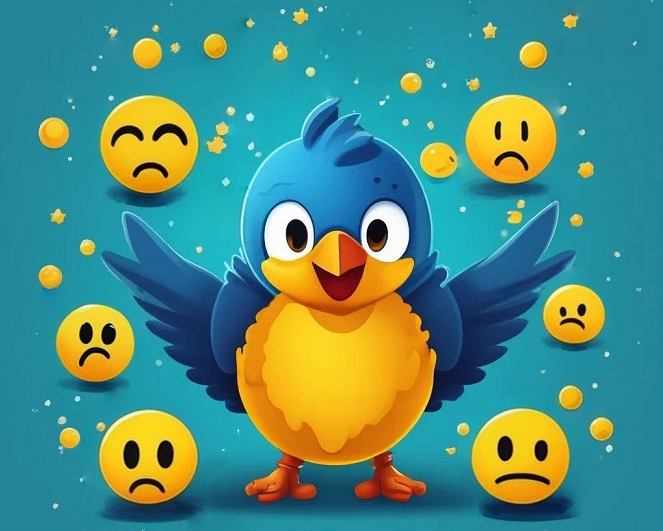

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Проверка-моделей-на-тестовой-выборке" data-toc-modified-id="Проверка-моделей-на-тестовой-выборке-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка моделей на тестовой выборке</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

In [1]:
%%time
import numpy as np
import pandas as pd
import transformers
from pymystem3 import Mystem
import re
import tqdm
from tqdm import notebook
from tqdm.notebook import tqdm
import nltk
from sklearn.model_selection import cross_val_score, train_test_split
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
#добавил загрузку нового лемматизатора
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag

CPU times: user 1.2 s, sys: 399 ms, total: 1.6 s
Wall time: 2.13 s


In [2]:
%%time
try:
    df = pd.read_csv('C://datasets/toxic_comments.csv')


except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


CPU times: user 829 ms, sys: 287 ms, total: 1.12 s
Wall time: 2.56 s


In [3]:
df['toxic'].describe()

count    159292.000000
mean          0.101612
std           0.302139
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64

In [4]:
df['text'].duplicated().sum()

0

Данные неплохие, пропусков нет, дубликатов нет. 
    
- Столбец ''Unnamed: 0', который появляетася, когда пересобираешь таблицы. Индекс дата сета и этого столбца отличается на 159 штук. Видимо, агент ФСБ прокрался в наш датасет и украл 159 комментариев про [ДАННЫЕ УДАЛЕНЫ]. Доделаем за него работу и устраним улики, удалив этот бесполезный столбец.
    
- Токсичных комментариев всего 10%. На удивление немного. Дисбаланс классов нужно будет учесть при составлении выборок.

- Необходима лемматизация.

In [5]:
df = df.drop('Unnamed: 0', axis = 1)
df.tail()

,text,toxic
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0
159291,"""\nAnd ... I really don't think you understand...",0


In [6]:
corpus = list(df['text'])

def clear_text(text):
    text = text.lower()
    
    text = re.sub(r"'s", "", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"you're", "you are ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"http", "", text)
    text = re.sub(r"https", "", text)
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.split()
    text = " ".join(text)
    return text

In [7]:
wordnet = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [8]:
def lemmatize(text):
    lemm_text = []
    for token,tag in pos_tag(word_tokenize(text)):
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
        lemm_list = wordnet.lemmatize(token,pos)
        lemm_text = lemm_text + [lemm_list]
    lemm_text = " ".join(lemm_text)

    return lemm_text

In [9]:
z = 555
print("Исходный текст:", corpus[z])
print("-----------------------------------------")
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[z])))
print("-----------------------------------------")
print("Просто очищенный текст:", clear_text(corpus[z]))

Исходный текст: "

 Image 

 Image deletion warning Image:Metroid Prime Hunter title screen, top display.jpg has been listed at Wikipedia:Images and media for deletion. If you feel that this image should not be deleted, please go there to voice your opinion.
 16:31, August 31, 2005 (UTC)"
-----------------------------------------
Очищенный и лемматизированный текст: image image deletion warn image metroid prime hunter title screen top display jpg have be list at wikipedia image and medium for deletion if you feel that this image should not be delete please go there to voice your opinion august utc
-----------------------------------------
Просто очищенный текст: image image deletion warning image metroid prime hunter title screen top display jpg has been listed at wikipedia images and media for deletion if you feel that this image should not be deleted please go there to voice your opinion august utc


In [10]:
%%time
df['txt_lemm'] = df['text']
for i in notebook.tqdm(range(len(df))):
    df['txt_lemm'][i] =lemmatize(clear_text(df['text'][i]))    


  0%|          | 0/159292 [00:00<?, ?it/s]

<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 18min 2s, sys: 13.9 s, total: 18min 16s
Wall time: 18min 47s


In [11]:
z = 555
print("Исходный текст:", df['text'][z])
print("-----------------------------------------")
print("Очищенный текст:", df['txt_lemm'][z])

Исходный текст: "

 Image 

 Image deletion warning Image:Metroid Prime Hunter title screen, top display.jpg has been listed at Wikipedia:Images and media for deletion. If you feel that this image should not be deleted, please go there to voice your opinion.
 16:31, August 31, 2005 (UTC)"
-----------------------------------------
Очищенный текст: image image deletion warn image metroid prime hunter title screen top display jpg have be list at wikipedia image and medium for deletion if you feel that this image should not be delete please go there to voice your opinion august utc


In [12]:
df_ml = df.filter(['txt_lemm','toxic'], axis=1)
df_ml

,txt_lemm,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i be see...,0
2,hey man i be really not try to edit war it jus...,0
3,more i can not make any real suggestion on imp...,0
4,you sir be my hero any chance you remember wha...,0
...,...,...
159287,and for the second time of ask when your view ...,0
159288,you should be ashamed of yourself that be a ho...,0
159289,spitzer umm theres no actual article for prost...,0
159290,and it look like it be actually you who put on...,0


In [13]:
df_ml = df_ml.rename(columns={"txt_lemm": "txt"})
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   txt     159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


## Обучение

In [14]:
rnd = 12345

In [15]:
features = df_ml['txt']
target = df_ml['toxic']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=rnd, stratify = target)

In [16]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)
print(target_train.describe())
print(target_test.describe())

(119469,)
(119469,)
(39823,)
(39823,)
count    119469.000000
mean          0.101616
std           0.302144
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64
count    39823.000000
mean         0.101600
std          0.302125
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: toxic, dtype: float64


- Разбили выборки, проверили, что дисбаланс одинаково распределен между тестовой и тренировочной выобрками.
    
- Далее - очистка мешка слов от стоп-слов и векторизация.

In [17]:
%%time
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit(features_train)

features_train = tf_idf.transform(features_train)
features_test = tf_idf.transform(features_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 12.1 s, sys: 117 ms, total: 12.2 s
Wall time: 12.4 s


In [18]:
display(features_train)
display(features_test)

<119469x131450 sparse matrix of type '<class 'numpy.float64'>'
	with 3139909 stored elements in Compressed Sparse Row format>

<39823x131450 sparse matrix of type '<class 'numpy.float64'>'
	with 1014017 stored elements in Compressed Sparse Row format>

In [19]:
%%time
model = DecisionTreeClassifier(splitter = 'random')
model.fit(features_train, target_train)

CPU times: user 2min 26s, sys: 140 ms, total: 2min 26s
Wall time: 2min 26s


DecisionTreeClassifier(splitter='random')

In [20]:
predictions = model.predict(features_train)
f1 = f1_score(target_train, predictions)
print(f1)

0.9984331189180273


In [21]:
%%time
model2 = RandomForestClassifier()
model2.fit(features_train, target_train)

CPU times: user 9min 4s, sys: 676 ms, total: 9min 4s
Wall time: 9min 5s


RandomForestClassifier()

In [22]:
%%time
predictions2 = model2.predict(features_train)
f1_2 = f1_score(target_train, predictions2)
print(f1_2)

0.9983924817608507
CPU times: user 18 s, sys: 29.7 ms, total: 18.1 s
Wall time: 18.1 s


In [23]:
%%time
model3 = LogisticRegression(random_state = rnd, class_weight = 'balanced', C = 10, fit_intercept = True)
model3.fit(features_train, target_train)

CPU times: user 22.5 s, sys: 25.4 s, total: 47.8 s
Wall time: 47.8 s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, class_weight='balanced', random_state=12345)

In [24]:
predictions3 = model3.predict(features_train)
f1_3 = f1_score(target_train, predictions3)
print(f1_3)

0.9051571949066597


In [25]:
%%time
model4 = CatBoostClassifier(learning_rate=0.7, loss_function='Logloss', logging_level='Verbose')
model4_v2 = CatBoostClassifier(learning_rate=0.3, loss_function='Logloss', logging_level='Verbose')
model4.fit(features_train, target_train)
model4_v2.fit(features_train, target_train)

0:	learn: 0.2879677	total: 2.97s	remaining: 49m 24s
1:	learn: 0.2359688	total: 5.18s	remaining: 43m 5s
2:	learn: 0.2171523	total: 7.38s	remaining: 40m 52s
3:	learn: 0.2069989	total: 9.44s	remaining: 39m 9s
4:	learn: 0.1998768	total: 11.6s	remaining: 38m 22s
5:	learn: 0.1931422	total: 13.7s	remaining: 37m 47s
6:	learn: 0.1868182	total: 15.8s	remaining: 37m 21s
7:	learn: 0.1822542	total: 17.9s	remaining: 37m 1s
8:	learn: 0.1782955	total: 19.9s	remaining: 36m 31s
9:	learn: 0.1741402	total: 22s	remaining: 36m 17s
10:	learn: 0.1714629	total: 23.9s	remaining: 35m 51s
11:	learn: 0.1688123	total: 26s	remaining: 35m 40s
12:	learn: 0.1666377	total: 28s	remaining: 35m 24s
13:	learn: 0.1647065	total: 29.9s	remaining: 35m 5s
14:	learn: 0.1628903	total: 31.9s	remaining: 34m 52s
15:	learn: 0.1605583	total: 33.8s	remaining: 34m 40s
16:	learn: 0.1590007	total: 35.8s	remaining: 34m 31s
17:	learn: 0.1566989	total: 37.8s	remaining: 34m 22s
18:	learn: 0.1552815	total: 39.8s	remaining: 34m 13s
19:	learn: 0.

153:	learn: 0.0988943	total: 5m 8s	remaining: 28m 14s
154:	learn: 0.0985993	total: 5m 10s	remaining: 28m 13s
155:	learn: 0.0985077	total: 5m 12s	remaining: 28m 11s
156:	learn: 0.0984198	total: 5m 14s	remaining: 28m 9s
157:	learn: 0.0980623	total: 5m 16s	remaining: 28m 8s
158:	learn: 0.0978361	total: 5m 18s	remaining: 28m 6s
159:	learn: 0.0977431	total: 5m 20s	remaining: 28m 4s
160:	learn: 0.0974657	total: 5m 23s	remaining: 28m 3s
161:	learn: 0.0973210	total: 5m 25s	remaining: 28m 1s
162:	learn: 0.0971782	total: 5m 27s	remaining: 27m 59s
163:	learn: 0.0969987	total: 5m 29s	remaining: 27m 57s
164:	learn: 0.0968130	total: 5m 31s	remaining: 27m 56s
165:	learn: 0.0964688	total: 5m 33s	remaining: 27m 54s
166:	learn: 0.0963610	total: 5m 35s	remaining: 27m 52s
167:	learn: 0.0962617	total: 5m 37s	remaining: 27m 50s
168:	learn: 0.0959953	total: 5m 39s	remaining: 27m 49s
169:	learn: 0.0957961	total: 5m 41s	remaining: 27m 47s
170:	learn: 0.0956908	total: 5m 43s	remaining: 27m 45s
171:	learn: 0.095

304:	learn: 0.0802719	total: 10m 5s	remaining: 22m 59s
305:	learn: 0.0801927	total: 10m 7s	remaining: 22m 57s
306:	learn: 0.0801153	total: 10m 9s	remaining: 22m 55s
307:	learn: 0.0800378	total: 10m 11s	remaining: 22m 53s
308:	learn: 0.0799603	total: 10m 13s	remaining: 22m 51s
309:	learn: 0.0797119	total: 10m 15s	remaining: 22m 49s
310:	learn: 0.0796494	total: 10m 17s	remaining: 22m 47s
311:	learn: 0.0794200	total: 10m 19s	remaining: 22m 45s
312:	learn: 0.0793317	total: 10m 21s	remaining: 22m 43s
313:	learn: 0.0792501	total: 10m 22s	remaining: 22m 41s
314:	learn: 0.0791776	total: 10m 24s	remaining: 22m 38s
315:	learn: 0.0791064	total: 10m 26s	remaining: 22m 36s
316:	learn: 0.0790269	total: 10m 28s	remaining: 22m 34s
317:	learn: 0.0789507	total: 10m 30s	remaining: 22m 32s
318:	learn: 0.0787640	total: 10m 32s	remaining: 22m 30s
319:	learn: 0.0786928	total: 10m 34s	remaining: 22m 28s
320:	learn: 0.0786226	total: 10m 36s	remaining: 22m 26s
321:	learn: 0.0785435	total: 10m 38s	remaining: 22m

452:	learn: 0.0682003	total: 14m 50s	remaining: 17m 54s
453:	learn: 0.0681480	total: 14m 52s	remaining: 17m 52s
454:	learn: 0.0680987	total: 14m 53s	remaining: 17m 50s
455:	learn: 0.0679371	total: 14m 56s	remaining: 17m 49s
456:	learn: 0.0678874	total: 14m 58s	remaining: 17m 46s
457:	learn: 0.0678398	total: 14m 59s	remaining: 17m 44s
458:	learn: 0.0677860	total: 15m 1s	remaining: 17m 42s
459:	learn: 0.0677353	total: 15m 3s	remaining: 17m 40s
460:	learn: 0.0676839	total: 15m 5s	remaining: 17m 38s
461:	learn: 0.0676404	total: 15m 7s	remaining: 17m 36s
462:	learn: 0.0675934	total: 15m 9s	remaining: 17m 34s
463:	learn: 0.0673654	total: 15m 11s	remaining: 17m 32s
464:	learn: 0.0671963	total: 15m 13s	remaining: 17m 30s
465:	learn: 0.0671454	total: 15m 15s	remaining: 17m 28s
466:	learn: 0.0670963	total: 15m 17s	remaining: 17m 26s
467:	learn: 0.0670468	total: 15m 19s	remaining: 17m 24s
468:	learn: 0.0668680	total: 15m 21s	remaining: 17m 22s
469:	learn: 0.0668374	total: 15m 23s	remaining: 17m 2

600:	learn: 0.0592706	total: 19m 34s	remaining: 12m 59s
601:	learn: 0.0592320	total: 19m 36s	remaining: 12m 57s
602:	learn: 0.0591944	total: 19m 38s	remaining: 12m 56s
603:	learn: 0.0591556	total: 19m 40s	remaining: 12m 54s
604:	learn: 0.0591154	total: 19m 42s	remaining: 12m 52s
605:	learn: 0.0590223	total: 19m 44s	remaining: 12m 50s
606:	learn: 0.0589859	total: 19m 46s	remaining: 12m 48s
607:	learn: 0.0587727	total: 19m 48s	remaining: 12m 46s
608:	learn: 0.0587425	total: 19m 50s	remaining: 12m 44s
609:	learn: 0.0586602	total: 19m 52s	remaining: 12m 42s
610:	learn: 0.0586217	total: 19m 54s	remaining: 12m 40s
611:	learn: 0.0585844	total: 19m 56s	remaining: 12m 38s
612:	learn: 0.0584357	total: 19m 58s	remaining: 12m 36s
613:	learn: 0.0584065	total: 20m	remaining: 12m 34s
614:	learn: 0.0582146	total: 20m 2s	remaining: 12m 32s
615:	learn: 0.0581805	total: 20m 4s	remaining: 12m 30s
616:	learn: 0.0581437	total: 20m 6s	remaining: 12m 29s
617:	learn: 0.0579756	total: 20m 8s	remaining: 12m 27s


749:	learn: 0.0512719	total: 24m 25s	remaining: 8m 8s
750:	learn: 0.0512485	total: 24m 27s	remaining: 8m 6s
751:	learn: 0.0512209	total: 24m 28s	remaining: 8m 4s
752:	learn: 0.0511930	total: 24m 30s	remaining: 8m 2s
753:	learn: 0.0510523	total: 24m 32s	remaining: 8m
754:	learn: 0.0510242	total: 24m 34s	remaining: 7m 58s
755:	learn: 0.0509973	total: 24m 36s	remaining: 7m 56s
756:	learn: 0.0508613	total: 24m 38s	remaining: 7m 54s
757:	learn: 0.0507540	total: 24m 40s	remaining: 7m 52s
758:	learn: 0.0507251	total: 24m 42s	remaining: 7m 50s
759:	learn: 0.0506990	total: 24m 44s	remaining: 7m 48s
760:	learn: 0.0506711	total: 24m 46s	remaining: 7m 46s
761:	learn: 0.0506436	total: 24m 48s	remaining: 7m 44s
762:	learn: 0.0506157	total: 24m 50s	remaining: 7m 42s
763:	learn: 0.0505768	total: 24m 52s	remaining: 7m 40s
764:	learn: 0.0505360	total: 24m 54s	remaining: 7m 38s
765:	learn: 0.0505079	total: 24m 56s	remaining: 7m 37s
766:	learn: 0.0504804	total: 24m 58s	remaining: 7m 35s
767:	learn: 0.0504

899:	learn: 0.0452197	total: 29m 15s	remaining: 3m 15s
900:	learn: 0.0451946	total: 29m 16s	remaining: 3m 13s
901:	learn: 0.0450958	total: 29m 18s	remaining: 3m 11s
902:	learn: 0.0450718	total: 29m 20s	remaining: 3m 9s
903:	learn: 0.0450484	total: 29m 22s	remaining: 3m 7s
904:	learn: 0.0449864	total: 29m 24s	remaining: 3m 5s
905:	learn: 0.0449643	total: 29m 26s	remaining: 3m 3s
906:	learn: 0.0449422	total: 29m 28s	remaining: 3m 1s
907:	learn: 0.0449195	total: 29m 30s	remaining: 2m 59s
908:	learn: 0.0448851	total: 29m 32s	remaining: 2m 57s
909:	learn: 0.0448623	total: 29m 34s	remaining: 2m 55s
910:	learn: 0.0448418	total: 29m 36s	remaining: 2m 53s
911:	learn: 0.0448163	total: 29m 38s	remaining: 2m 51s
912:	learn: 0.0447962	total: 29m 40s	remaining: 2m 49s
913:	learn: 0.0447308	total: 29m 42s	remaining: 2m 47s
914:	learn: 0.0447092	total: 29m 44s	remaining: 2m 45s
915:	learn: 0.0446863	total: 29m 46s	remaining: 2m 43s
916:	learn: 0.0446658	total: 29m 48s	remaining: 2m 41s
917:	learn: 0.0

52:	learn: 0.1515454	total: 1m 49s	remaining: 32m 36s
53:	learn: 0.1510898	total: 1m 51s	remaining: 32m 32s
54:	learn: 0.1503178	total: 1m 53s	remaining: 32m 31s
55:	learn: 0.1496907	total: 1m 55s	remaining: 32m 30s
56:	learn: 0.1492227	total: 1m 57s	remaining: 32m 29s
57:	learn: 0.1488270	total: 1m 59s	remaining: 32m 26s
58:	learn: 0.1482445	total: 2m 1s	remaining: 32m 23s
59:	learn: 0.1478276	total: 2m 3s	remaining: 32m 19s
60:	learn: 0.1469619	total: 2m 5s	remaining: 32m 17s
61:	learn: 0.1464344	total: 2m 7s	remaining: 32m 15s
62:	learn: 0.1458871	total: 2m 9s	remaining: 32m 13s
63:	learn: 0.1450036	total: 2m 11s	remaining: 32m 10s
64:	learn: 0.1446803	total: 2m 13s	remaining: 32m 5s
65:	learn: 0.1441740	total: 2m 15s	remaining: 32m 2s
66:	learn: 0.1436618	total: 2m 17s	remaining: 32m
67:	learn: 0.1432968	total: 2m 19s	remaining: 31m 56s
68:	learn: 0.1429237	total: 2m 21s	remaining: 31m 52s
69:	learn: 0.1425344	total: 2m 23s	remaining: 31m 49s
70:	learn: 0.1422116	total: 2m 25s	rema

203:	learn: 0.1133555	total: 6m 46s	remaining: 26m 27s
204:	learn: 0.1132804	total: 6m 48s	remaining: 26m 24s
205:	learn: 0.1131982	total: 6m 50s	remaining: 26m 22s
206:	learn: 0.1131234	total: 6m 52s	remaining: 26m 20s
207:	learn: 0.1130521	total: 6m 54s	remaining: 26m 18s
208:	learn: 0.1129835	total: 6m 56s	remaining: 26m 16s
209:	learn: 0.1129158	total: 6m 58s	remaining: 26m 13s
210:	learn: 0.1128183	total: 7m	remaining: 26m 11s
211:	learn: 0.1125647	total: 7m 2s	remaining: 26m 10s
212:	learn: 0.1123573	total: 7m 4s	remaining: 26m 8s
213:	learn: 0.1122878	total: 7m 6s	remaining: 26m 5s
214:	learn: 0.1122205	total: 7m 8s	remaining: 26m 3s
215:	learn: 0.1120254	total: 7m 10s	remaining: 26m 1s
216:	learn: 0.1117918	total: 7m 12s	remaining: 25m 59s
217:	learn: 0.1116448	total: 7m 14s	remaining: 25m 57s
218:	learn: 0.1115481	total: 7m 16s	remaining: 25m 55s
219:	learn: 0.1114816	total: 7m 18s	remaining: 25m 53s
220:	learn: 0.1112641	total: 7m 20s	remaining: 25m 52s
221:	learn: 0.1112001	

353:	learn: 0.0981812	total: 11m 42s	remaining: 21m 21s
354:	learn: 0.0980355	total: 11m 44s	remaining: 21m 20s
355:	learn: 0.0979890	total: 11m 46s	remaining: 21m 17s
356:	learn: 0.0979381	total: 11m 48s	remaining: 21m 15s
357:	learn: 0.0977489	total: 11m 50s	remaining: 21m 13s
358:	learn: 0.0977084	total: 11m 52s	remaining: 21m 11s
359:	learn: 0.0976636	total: 11m 54s	remaining: 21m 9s
360:	learn: 0.0976162	total: 11m 56s	remaining: 21m 7s
361:	learn: 0.0975761	total: 11m 58s	remaining: 21m 5s
362:	learn: 0.0975353	total: 11m 59s	remaining: 21m 3s
363:	learn: 0.0974857	total: 12m 1s	remaining: 21m 1s
364:	learn: 0.0973538	total: 12m 3s	remaining: 20m 59s
365:	learn: 0.0971894	total: 12m 6s	remaining: 20m 57s
366:	learn: 0.0971356	total: 12m 8s	remaining: 20m 55s
367:	learn: 0.0970910	total: 12m 10s	remaining: 20m 53s
368:	learn: 0.0969842	total: 12m 12s	remaining: 20m 51s
369:	learn: 0.0969406	total: 12m 14s	remaining: 20m 49s
370:	learn: 0.0968461	total: 12m 16s	remaining: 20m 48s
3

501:	learn: 0.0894366	total: 16m 30s	remaining: 16m 22s
502:	learn: 0.0894042	total: 16m 32s	remaining: 16m 20s
503:	learn: 0.0893721	total: 16m 34s	remaining: 16m 18s
504:	learn: 0.0893394	total: 16m 36s	remaining: 16m 16s
505:	learn: 0.0893033	total: 16m 38s	remaining: 16m 14s
506:	learn: 0.0891847	total: 16m 40s	remaining: 16m 12s
507:	learn: 0.0891531	total: 16m 42s	remaining: 16m 10s
508:	learn: 0.0891172	total: 16m 44s	remaining: 16m 8s
509:	learn: 0.0890846	total: 16m 46s	remaining: 16m 6s
510:	learn: 0.0890514	total: 16m 48s	remaining: 16m 4s
511:	learn: 0.0890209	total: 16m 50s	remaining: 16m 2s
512:	learn: 0.0889540	total: 16m 52s	remaining: 16m
513:	learn: 0.0889197	total: 16m 54s	remaining: 15m 58s
514:	learn: 0.0888863	total: 16m 56s	remaining: 15m 56s
515:	learn: 0.0888541	total: 16m 58s	remaining: 15m 54s
516:	learn: 0.0888215	total: 17m	remaining: 15m 52s
517:	learn: 0.0887881	total: 17m 2s	remaining: 15m 50s
518:	learn: 0.0887559	total: 17m 3s	remaining: 15m 48s
519:	l

649:	learn: 0.0827930	total: 21m 23s	remaining: 11m 31s
650:	learn: 0.0827102	total: 21m 25s	remaining: 11m 29s
651:	learn: 0.0826337	total: 21m 27s	remaining: 11m 27s
652:	learn: 0.0826046	total: 21m 29s	remaining: 11m 25s
653:	learn: 0.0825773	total: 21m 31s	remaining: 11m 23s
654:	learn: 0.0825497	total: 21m 32s	remaining: 11m 21s
655:	learn: 0.0825244	total: 21m 34s	remaining: 11m 19s
656:	learn: 0.0824950	total: 21m 36s	remaining: 11m 16s
657:	learn: 0.0824686	total: 21m 38s	remaining: 11m 14s
658:	learn: 0.0824428	total: 21m 40s	remaining: 11m 12s
659:	learn: 0.0823958	total: 21m 42s	remaining: 11m 11s
660:	learn: 0.0823703	total: 21m 44s	remaining: 11m 9s
661:	learn: 0.0823342	total: 21m 46s	remaining: 11m 7s
662:	learn: 0.0823049	total: 21m 48s	remaining: 11m 5s
663:	learn: 0.0822739	total: 21m 50s	remaining: 11m 3s
664:	learn: 0.0822481	total: 21m 52s	remaining: 11m 1s
665:	learn: 0.0822209	total: 21m 54s	remaining: 10m 59s
666:	learn: 0.0821946	total: 21m 56s	remaining: 10m 5

799:	learn: 0.0772939	total: 26m 18s	remaining: 6m 34s
800:	learn: 0.0772701	total: 26m 20s	remaining: 6m 32s
801:	learn: 0.0772462	total: 26m 22s	remaining: 6m 30s
802:	learn: 0.0772224	total: 26m 24s	remaining: 6m 28s
803:	learn: 0.0771988	total: 26m 26s	remaining: 6m 26s
804:	learn: 0.0771204	total: 26m 28s	remaining: 6m 24s
805:	learn: 0.0770979	total: 26m 30s	remaining: 6m 22s
806:	learn: 0.0770741	total: 26m 31s	remaining: 6m 20s
807:	learn: 0.0769882	total: 26m 33s	remaining: 6m 18s
808:	learn: 0.0769151	total: 26m 36s	remaining: 6m 16s
809:	learn: 0.0768912	total: 26m 38s	remaining: 6m 14s
810:	learn: 0.0768697	total: 26m 40s	remaining: 6m 12s
811:	learn: 0.0768467	total: 26m 41s	remaining: 6m 10s
812:	learn: 0.0768232	total: 26m 43s	remaining: 6m 8s
813:	learn: 0.0767524	total: 26m 45s	remaining: 6m 6s
814:	learn: 0.0767295	total: 26m 47s	remaining: 6m 4s
815:	learn: 0.0767061	total: 26m 49s	remaining: 6m 2s
816:	learn: 0.0766132	total: 26m 51s	remaining: 6m 1s
817:	learn: 0.0

950:	learn: 0.0722208	total: 31m 9s	remaining: 1m 36s
951:	learn: 0.0722017	total: 31m 11s	remaining: 1m 34s
952:	learn: 0.0721770	total: 31m 13s	remaining: 1m 32s
953:	learn: 0.0721464	total: 31m 15s	remaining: 1m 30s
954:	learn: 0.0721257	total: 31m 17s	remaining: 1m 28s
955:	learn: 0.0721072	total: 31m 19s	remaining: 1m 26s
956:	learn: 0.0720870	total: 31m 21s	remaining: 1m 24s
957:	learn: 0.0720675	total: 31m 23s	remaining: 1m 22s
958:	learn: 0.0720479	total: 31m 25s	remaining: 1m 20s
959:	learn: 0.0720169	total: 31m 26s	remaining: 1m 18s
960:	learn: 0.0719980	total: 31m 28s	remaining: 1m 16s
961:	learn: 0.0719791	total: 31m 30s	remaining: 1m 14s
962:	learn: 0.0719454	total: 31m 32s	remaining: 1m 12s
963:	learn: 0.0719266	total: 31m 34s	remaining: 1m 10s
964:	learn: 0.0718967	total: 31m 36s	remaining: 1m 8s
965:	learn: 0.0718099	total: 31m 38s	remaining: 1m 6s
966:	learn: 0.0717904	total: 31m 40s	remaining: 1m 4s
967:	learn: 0.0717173	total: 31m 42s	remaining: 1m 2s
968:	learn: 0.0

In [26]:
%%time
predictions4 = model4.predict(features_train)
predictions4_v2 = model4_v2.predict(features_train)
f1_4 = f1_score(target_train, predictions4)
f1_4_v2 = f1_score(target_train, predictions4_v2)
print(f1_4)
print(f1_4_v2)

0.9571398349904803
0.8525685009834865
CPU times: user 4.31 s, sys: 32.1 ms, total: 4.34 s
Wall time: 4.36 s


In [27]:
print(f1, f1_2, f1_3, f1_4, f1_4_v2)

0.9984331189180273 0.9983924817608507 0.9051571949066597 0.9571398349904803 0.8525685009834865



|  Модель  | F1 на обучающей выборке | F1 на тестовой выборке |
|----------|---------------------------|--------------------------|
| DecisionTreeClassifier        | 0.998 | ? |
| RandomForestClassifier     | 0.998 | ? |
| LogisticRegression   | 0.905 | ? |
| CatBoostRegressor       | 0.957 | ? |
| CatBoostRegressor_v2    |  0.852 | ? |

## Проверка моделей на тестовой выборке 

In [28]:
%%time
predictions = model.predict(features_test)
f1 = f1_score(target_test, predictions)
print(f1)

0.7101248266296809
CPU times: user 137 ms, sys: 0 ns, total: 137 ms
Wall time: 151 ms


In [29]:
%%time
predictions2 = model2.predict(features_test)
f1_2 = f1_score(target_test, predictions2)
print(f1_2)

0.6835680751173709
CPU times: user 6.05 s, sys: 4.27 ms, total: 6.06 s
Wall time: 6.07 s


In [30]:
%%time
predictions3 = model3.predict(features_test)
f1_3 = f1_score(target_test, predictions3)
print(f1_3)

0.7594156585254509
CPU times: user 23.1 ms, sys: 24 µs, total: 23.1 ms
Wall time: 23 ms


In [31]:
%%time
predictions4 = model4.predict(features_test)
predictions4_v2 = model4_v2.predict(features_test)
f1_4 = f1_score(target_test, predictions4)
f1_4_v2 = f1_score(target_test, predictions4_v2)
print(f1_4)
print(f1_4_v2)

0.7640912840252956
0.765683945787341
CPU times: user 1.61 s, sys: 16.1 ms, total: 1.62 s
Wall time: 1.63 s


In [32]:
print(f1, f1_2, f1_3, f1_4, f1_4_v2)

0.7101248266296809 0.6835680751173709 0.7594156585254509 0.7640912840252956 0.765683945787341


|  Модель  | F1 на обучающей выборке | F1 на тестовой выборке |
|----------|---------------------------|--------------------------|
| DecisionTreeClassifier        | 0.998 | 0.710 |
| RandomForestClassifier     | 0.998 | 0.684 |
| LogisticRegression   | 0.853 | 0.759 |
| CatBoostRegressor       | 0.957 | 0.764 |
| CatBoostRegressor_v2    |  0.852 | 0.766 |

На тестовой выборке лучше всего себя показала модель:<b>
    
           CatBoostClassifier(learning_rate=0.3, loss_function='Logloss', logging_level='Verbose')

</b>Результат метрики f1 = 0,766


## Выводы

- Целевых метрик заказчика достигли только LogisticRegression	и CatBoostRegressor. Снижение скорости обучения улучшило модель catboost. Решающие деревья хуже справляются с обработкой огромных матриц текстов, чем модели градиентного бустинга. 
    
- Так же стоит отметить, что модель LogisticRegression справилась с поставленной задачей, а скорость её обучения в сотни раз ниже, чем у модели градиентного бустинга.

- Вероятно, стоит попробовать современные предобученные модели RUBERT или ELMO, но, к сожалению, наш сервер не справляется с этой нагрузкой.  